#### Récupération des données et définition des functions

In [177]:
import pandas as pd
import numpy as np
import pyodbc
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN

In [178]:
conn_str = 'Driver={ODBC Driver 18 for SQL Server};Server=tcp:mia10.database.windows.net,1433;Database=mia10_db;Uid=user_reader;Pwd=7R&o&o4#~756^z;Encrypt=yes;TrustServerCertificate=no;Connection Timeout=30;'

conn = pyodbc.connect(conn_str)

def fetch_data(conn, query, column_names):
    cursor = conn.cursor()
    cursor.execute(query)
    rows = cursor.fetchall()
    df = pd.DataFrame.from_records(rows, columns=column_names)
    cursor.close()
    return df

queries = {
    'athletes': ('SELECT * FROM athletes', ['athlete_full_name', 'country_id', 'athletes_id']),
    'country': ('SELECT * FROM country', ['country_name', 'country_code', 'country_id']),
    'events': ('SELECT * FROM events', ['index', 'game_name', 'game_season', 'game_year', 'start_date_str', 'end_date_str', 'country_id']),
    'medals': ('SELECT * FROM medals', ['discipline_title', 'slug_game', 'event_title', 'event_gender', 'medal_type', 'participant_type', 'athlete_country_id', 'athlete_id'])
}
# queries = {
#     'athletes': ('SELECT * FROM athletes', ['athlete_full_name', 'country_id', 'athletes_id']),
#     'country': ('SELECT * FROM country', ['country_name', 'country_code', 'country_id']),
#     'events': ('SELECT * FROM events', ['index', 'game_name', 'game_season', 'game_year', 'start_date_str', 'end_date_str', 'country_id']),
#     'medals': ('SELECT * FROM medals m INNER JOIN athletes a USING(athletes_id)', ['discipline_title', 'slug_game', 'event_title', 'event_gender', 'medal_type', 'participant_type', 'athlete_country_id', 'athlete_id'])
# }

df_athletes = fetch_data(conn, *queries['athletes'])
df_country = fetch_data(conn, *queries['country'])
df_hosts = fetch_data(conn, *queries['events'])
df_medals = fetch_data(conn, *queries['medals'])

conn.close()

In [179]:
medals = df_medals.merge(df_country, left_on='athlete_country_id', right_on='country_id', how='left')
performance_df = medals[['country_name', 'medal_type']].copy()
medals_count = performance_df.pivot_table(index='country_name', columns='medal_type', aggfunc='size', fill_value=0)
medals_count.columns = ['Bronze', 'Gold', 'Silver']
medals_count['Total'] = medals_count.sum(axis=1)

In [180]:
def safe_eval(x):
    if isinstance(x, str):
        return eval(x)
    return x

In [181]:
def perform_clustering(data, title):
    medal_counts = data.groupby('country_name').agg(
        total_medals=pd.NamedAgg(column='medal_type', aggfunc='count'),
        gold_medals=pd.NamedAgg(column='medal_type', aggfunc=lambda x: (x == 'GOLD').sum())
    ).reset_index()

    scaler = StandardScaler()
    medal_counts_scaled = scaler.fit_transform(medal_counts[['total_medals', 'gold_medals']])

    kmeans = KMeans(n_clusters=3, random_state=0, n_init=10)
    medal_counts['Cluster'] = kmeans.fit_predict(medal_counts_scaled)

    plt.figure(figsize=(10, 7))
    plt.scatter(medal_counts['total_medals'], medal_counts['gold_medals'], c=medal_counts['Cluster'], cmap='viridis')
    plt.xlabel('Total Medals')
    plt.ylabel('Gold Medals')
    plt.title(title)
    plt.show()

    return medal_counts

#### Utilisation de la méthode du coude pour trouver le nombre de cluster optimal

In [182]:
medals.columns

Index(['discipline_title', 'slug_game', 'event_title', 'event_gender',
       'medal_type', 'participant_type', 'athlete_country_id', 'athlete_id',
       'country_name', 'country_code', 'country_id'],
      dtype='object')

In [183]:
df = medals.merge(df_athletes, left_on='athlete_id', right_on='athletes_id', how='left')

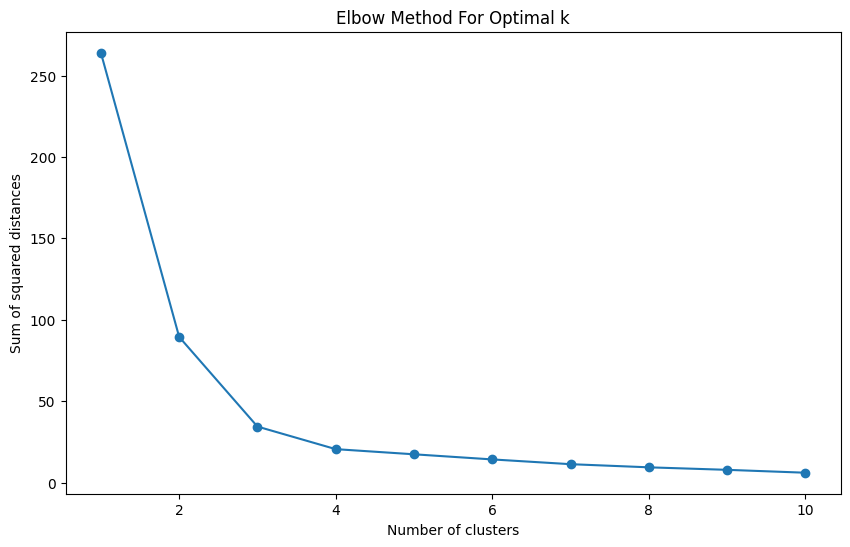

In [184]:
performance_df = df[['country_name', 'medal_type']].copy()
medals_count = performance_df.pivot_table(index='country_name', columns='medal_type', aggfunc='size', fill_value=0)
medals_count.columns = ['Bronze', 'Gold', 'Silver']
medals_count['Total'] = medals_count.sum(axis=1)

scaler = StandardScaler()
medals_scaled = scaler.fit_transform(medals_count)

sse = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10).fit(medals_scaled)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Comme le nombre de cluster 3 et 4 ont l'air d'être tous les deux optimaux, nous allons utiliser les indices de silhouette, de Davies Bouldin ainsi que l'indice de Calinski & Harabasz pour trouver le meilleur des deux.

In [185]:
df = df_w_outlier = df.drop(columns=['discipline_title', 'event_title', 'slug_game', 'participant_type', 'athlete_full_name'])

df['GOLD'] = df['medal_type'].apply(lambda x: 1 if x == 'GOLD' else 0)
df['SILVER'] = df['medal_type'].apply(lambda x: 1 if x == 'SILVER' else 0)
df['BRONZE'] = df['medal_type'].apply(lambda x: 1 if x == 'BRONZE' else 0)

df = df.fillna(0)
grouped_df = df.groupby('country_name').agg({'GOLD': 'sum', 'SILVER': 'sum', 'BRONZE': 'sum'})
grouped_df['TOTAL'] = grouped_df['GOLD'] + grouped_df['SILVER'] + grouped_df['BRONZE']

X = grouped_df[['GOLD', 'SILVER', 'BRONZE', 'TOTAL']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [186]:
kmeans = KMeans(n_clusters=4, n_init=10)
kmeans.fit(X_scaled)

grouped_df['cluster'] = kmeans.labels_

In [187]:
# Calculer l'indice de silhouette pour 4 clusters
silhouette = silhouette_score(X_scaled, kmeans.labels_)
print('Indice de silhouette :', silhouette)

Indice de silhouette : 0.6294365971597892


In [188]:
# Calculer le score de Davies-Bouldin pour 4 clusters
davies_bouldin = davies_bouldin_score(X_scaled, kmeans.labels_)
print('Score de Davies-Bouldin :', davies_bouldin)

Score de Davies-Bouldin : 0.6254187413800475


In [189]:
# Calculer l'index de Calinski & Harabasz pour 4 clusters
calinski_harabasz = calinski_harabasz_score(X_scaled, kmeans.labels_)
print('Score de Calinski-Harabasz :', calinski_harabasz)

Score de Calinski-Harabasz : 249.5723075707624


In [190]:
kmeans = KMeans(n_clusters=3, n_init=10)
kmeans.fit(X_scaled)

grouped_df['cluster'] = kmeans.labels_

In [191]:
# Calculer l'indice de silhouette pour 3 clusters
silhouette = silhouette_score(X_scaled, kmeans.labels_)
print('Indice de silhouette :', silhouette)

Indice de silhouette : 0.6503966459609019


In [192]:
# Calculer le score de Davies-Bouldin pour 3 clusters
davies_bouldin_score = davies_bouldin_score(X_scaled, kmeans.labels_)
print('Score de Davies-Bouldin :', davies_bouldin_score)

Score de Davies-Bouldin : 0.5297163636589136


In [193]:
# Calculer l'index de Calinski & Harabasz pour 3 clusters
calinski_harabasz_score = calinski_harabasz_score(X_scaled, kmeans.labels_)
print('Score de Calinski-Harabasz :', calinski_harabasz_score)

Score de Calinski-Harabasz : 214.67725506739987


On remarque que les indices sont généralements plus précis pour 3 clusters que pour 4. Nous allons donc utiliser 3 clusters

### Modèle Kmeans

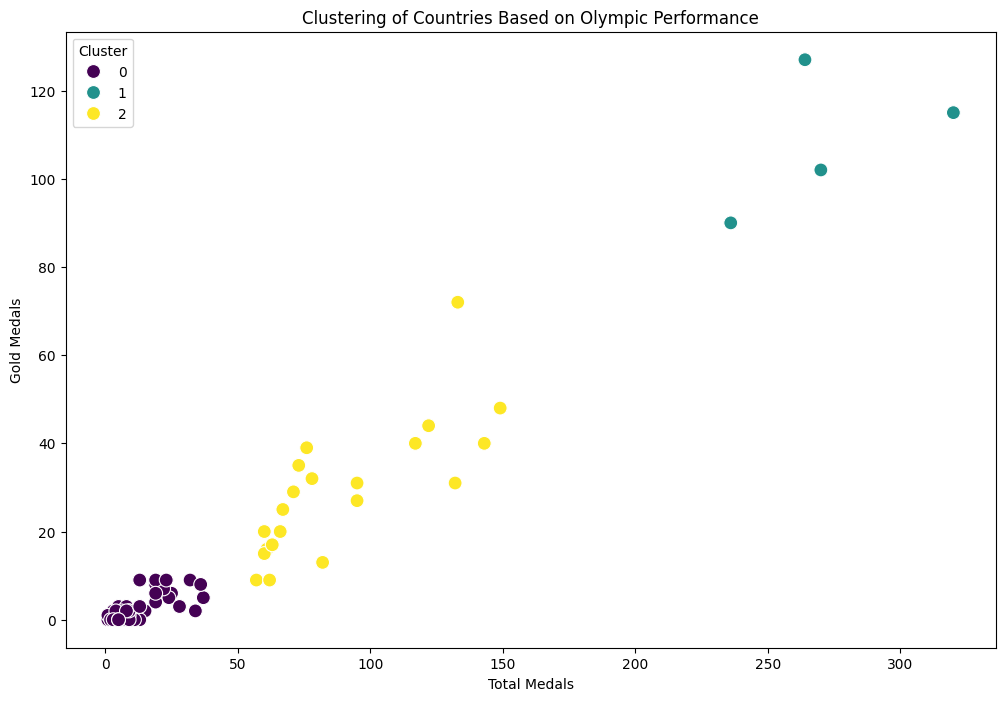

In [194]:
optimal_k = 3

kmeans = KMeans(n_clusters=optimal_k, random_state=0, n_init=10)
medals_count['Cluster'] = kmeans.fit_predict(medals_scaled)

plt.figure(figsize=(12, 8))
sns.scatterplot(data=medals_count, x='Total', y='Gold', hue='Cluster', palette='viridis', s=100)
plt.title('Clustering of Countries Based on Olympic Performance')
plt.xlabel('Total Medals')
plt.ylabel('Gold Medals')
plt.legend(title='Cluster')
plt.show()

In [195]:
medals_count.head()

,Bronze,Gold,Silver,Total,Cluster
country_name,,,,,
Argentina,15,6,4,25,0
Australia,62,48,39,149,2
Austria,22,16,23,61,2
Bahamas,1,2,0,3,0
Belarus,11,4,4,19,0


In [196]:
cluster_2_countries = medals_count[medals_count['Cluster'] == 2]
cluster_2_countries

,Bronze,Gold,Silver,Total,Cluster
country_name,,,,,
Australia,62,48,39,149,2
Austria,22,16,23,61,2
Brazil,24,20,16,60,2
Canada,54,31,47,132,2
Denmark,25,9,23,57,2
Federal Republic of Germany,22,15,23,60,2
France,65,40,38,143,2
German Democratic Republic (Germany),23,25,19,67,2
Hungary,44,27,24,95,2


Les américains toujours en avance sur le monde possèdent probablement des données aberrantes. Nous allons donc supprimer les données qui dépassent un seuil de 2.5 afin de réduire la marge.

In [197]:
medal_counts = df_w_outlier.groupby('country_name').agg(
    total_medals=pd.NamedAgg(column='medal_type', aggfunc='count'),
    gold_medals=pd.NamedAgg(column='medal_type', aggfunc=lambda x: (x == 'GOLD').sum())
).reset_index()

scaler = StandardScaler()
medal_counts_scaled = scaler.fit_transform(medal_counts[['total_medals', 'gold_medals']])

kmeans = KMeans(n_clusters=3, random_state=0, n_init=10)
medal_counts['Cluster'] = kmeans.fit_predict(medal_counts_scaled)

C:\Users\kirit\AppData\Local\Temp\ipykernel_16396\2688287260.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  medal_counts_no_outliers['Cluster'] = kmeans_no_outliers.fit_predict(medal_counts_no_outliers_scaled)


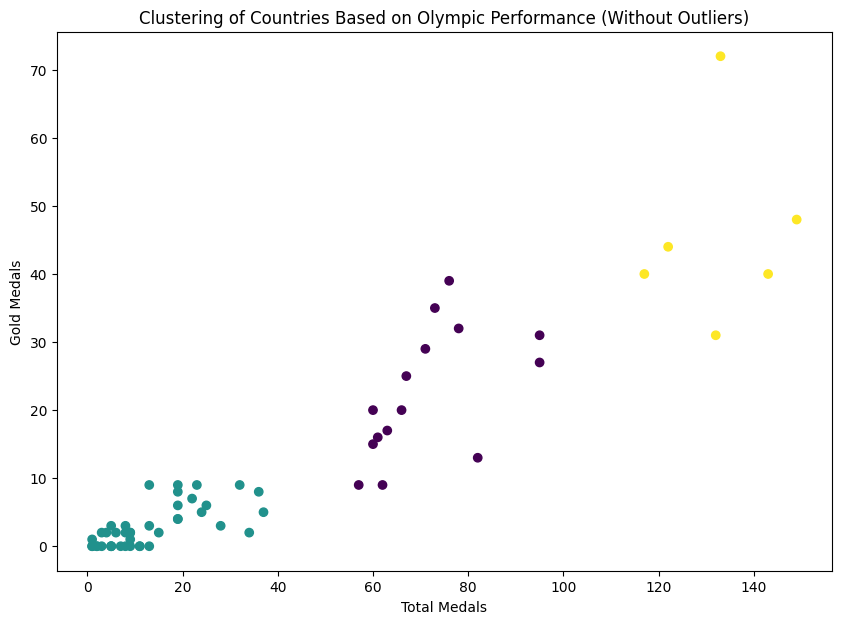

In [198]:
outlier_threshold = 2.5 
outliers = medal_counts[medal_counts['total_medals'] > outlier_threshold * medal_counts['total_medals'].std()]

medal_counts_no_outliers = medal_counts[~medal_counts['country_name'].isin(outliers['country_name'])]
medal_counts_no_outliers_scaled = scaler.fit_transform(medal_counts_no_outliers[['total_medals', 'gold_medals']])

kmeans_no_outliers = KMeans(n_clusters=3, random_state=0, n_init=10)
medal_counts_no_outliers['Cluster'] = kmeans_no_outliers.fit_predict(medal_counts_no_outliers_scaled)

plt.figure(figsize=(10, 7))
plt.scatter(medal_counts_no_outliers['total_medals'], medal_counts_no_outliers['gold_medals'], c=medal_counts_no_outliers['Cluster'], cmap='viridis')
plt.xlabel('Total Medals')
plt.ylabel('Gold Medals')
plt.title('Clustering of Countries Based on Olympic Performance (Without Outliers)')
plt.show()


On observe distinctement trois clusters qui représentent des groupes de perfomances au jo avec la plupart en cluster 1 avec des perfomances plutôt basses. Cependant ce graphique définie les perfomances d'un pays pour des JO toutes saisons confondues mais est-ce que les clusters seraient les mêmes avec une distinction de saisons ?

In [202]:
df_medals['slug_game'] = df_medals['slug_game'].str.split('-').str[-1]
df_combined = pd.merge(df_medals, df_hosts, left_on='slug_game', right_on='game_name')
df_combined = df_combined.merge(df_country, on='country_id')

summer_olympics = df_combined[df_combined['game_season'] == 'Summer']
winter_olympics = df_combined[df_combined['game_season'] == 'Winter']

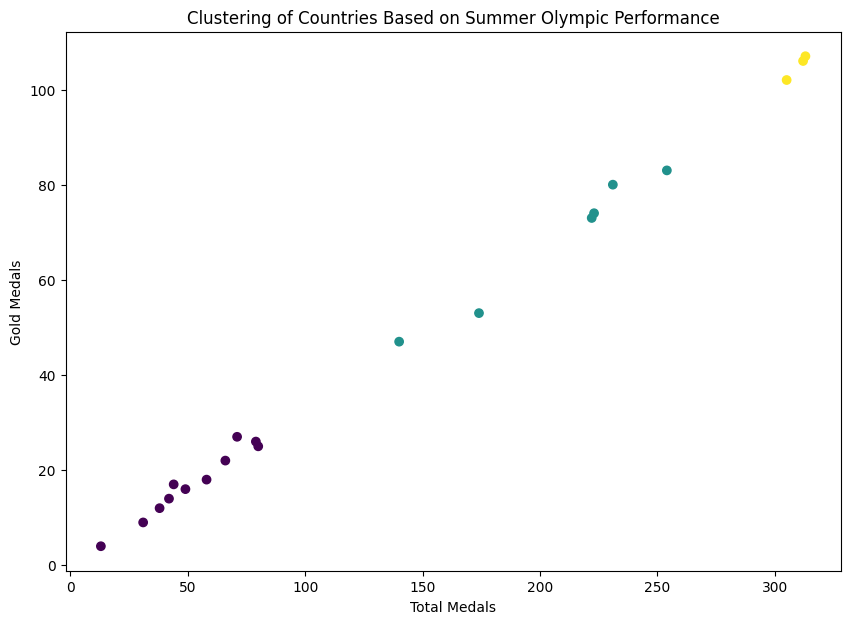

In [204]:
summer_clusters = perform_clustering(summer_olympics, 'Clustering of Countries Based on Summer Olympic Performance')

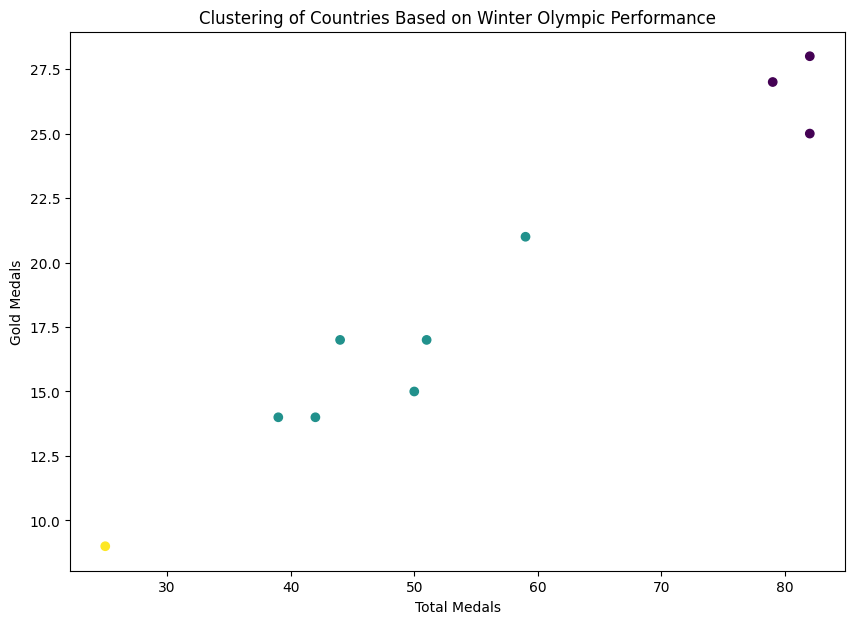

In [205]:
winter_clusters = perform_clustering(winter_olympics, 'Clustering of Countries Based on Winter Olympic Performance')

### Modèle Gaussian Mixture Models

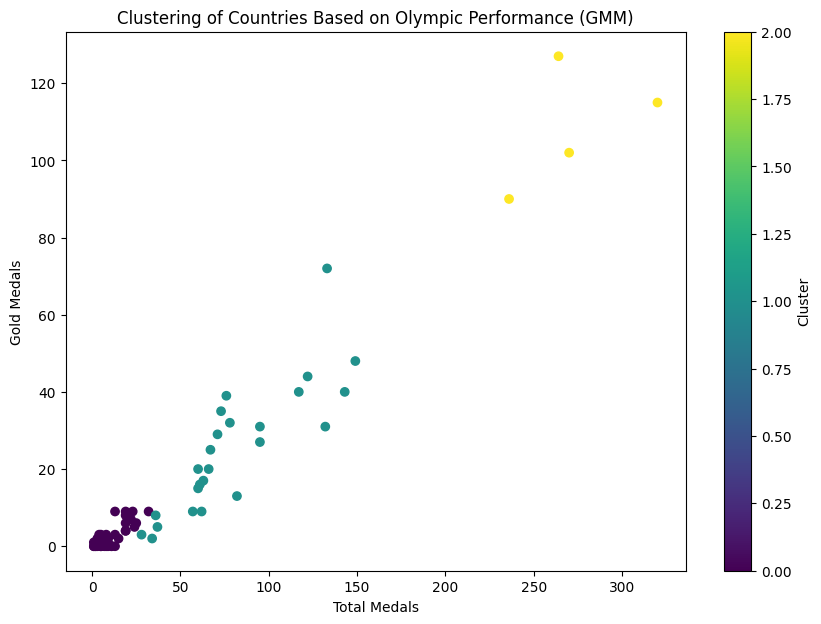

In [206]:
df_country = df.groupby('country_name').agg(
    total_medals=pd.NamedAgg(column='medal_type', aggfunc='count'),
    gold_medals=pd.NamedAgg(column='medal_type', aggfunc=lambda x: (x == 'GOLD').sum()),
    silver_medals=pd.NamedAgg(column='medal_type', aggfunc=lambda x: (x == 'SILVER').sum()),
    bronze_medals=pd.NamedAgg(column='medal_type', aggfunc=lambda x: (x == 'BRONZE').sum())
).reset_index()

X = df_country[['total_medals', 'gold_medals', 'silver_medals', 'bronze_medals']]
gmm = GaussianMixture(n_components=3, random_state=42)
df_country['Cluster'] = gmm.fit_predict(X)

plt.figure(figsize=(10, 7))
plt.scatter(df_country['total_medals'], df_country['gold_medals'], c=df_country['Cluster'], cmap='viridis')
plt.xlabel('Total Medals')
plt.ylabel('Gold Medals')
plt.title('Clustering of Countries Based on Olympic Performance (GMM)')
plt.colorbar(label='Cluster')
plt.show()


### Modèle Density Based Spatial Clustering of Applications with noise

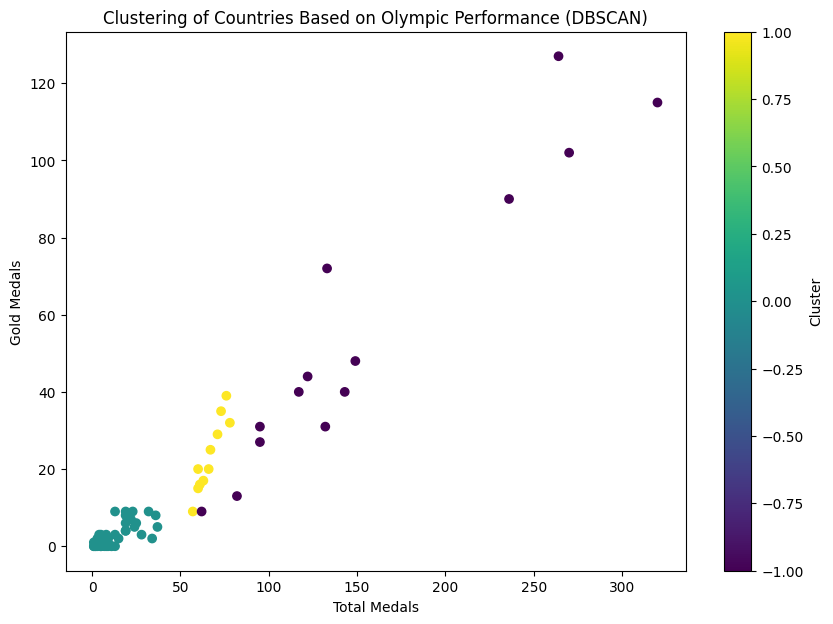

In [207]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

dbscan = DBSCAN(eps=0.5, min_samples=5)
df_country['Cluster'] = dbscan.fit_predict(X_scaled)

plt.figure(figsize=(10, 7))
plt.scatter(df_country['total_medals'], df_country['gold_medals'], c=df_country['Cluster'], cmap='viridis')
plt.xlabel('Total Medals')
plt.ylabel('Gold Medals')
plt.title('Clustering of Countries Based on Olympic Performance (DBSCAN)')
plt.colorbar(label='Cluster')
plt.show()

#### Sauvegarder les résultats

In [208]:
# medals_count.to_csv('data/olympic_clusters.csv')